# Spectral Density Peaks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from dadapy import Data
import tangentDistance as td
from functools import partial
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix
from scipy.stats import chi2
from scipy import special
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
)

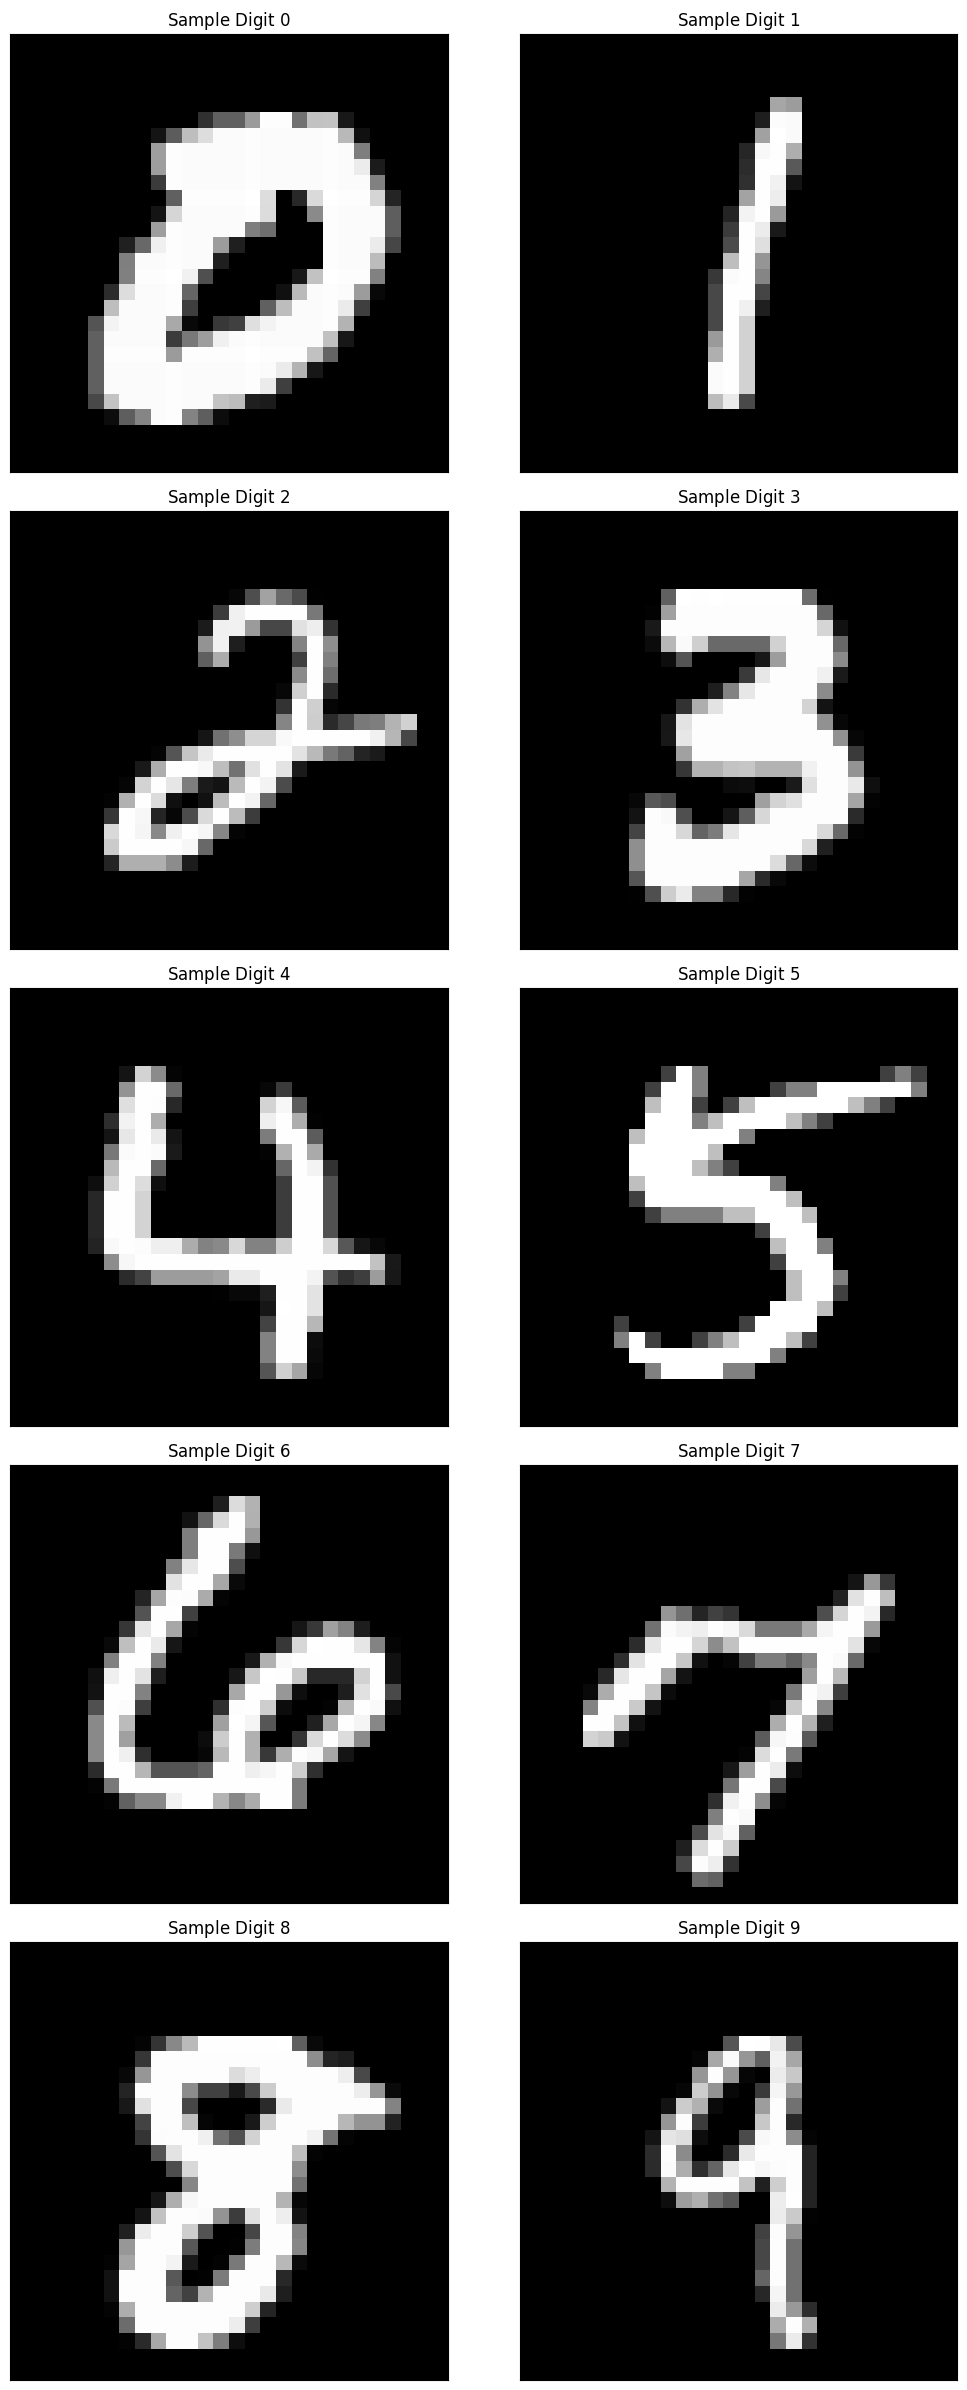

In [2]:
np.random.seed(42)
train_test_split = 60000
X_path = "./data/MNIST_X.dat"
y_path = "./data/MNIST_y.dat"
X = np.genfromtxt(fname=X_path, dtype=np.uint8)
y = np.genfromtxt(fname=y_path, dtype=np.uint8)
X = X[:train_test_split, :]
y = y[:train_test_split]
ncols = 2
nrows = int(np.ceil(len(np.unique(ar=y)) / 2))
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        ncols * plt.rcParams["figure.figsize"][0],
        nrows * plt.rcParams["figure.figsize"][1],
    ),
    layout="tight",
)
image_size = int(np.sqrt(X.shape[1]))
distinct_digits = np.unique(ar=y)
for ax, distinct_digit in zip(axs.flatten(), distinct_digits):
    title = rf"Sample Digit ${distinct_digit}$"
    ax.set(aspect="equal", title=title, xticks=[], yticks=[])
    digit_indices = np.where(y == distinct_digit)[0]
    random_index = np.random.choice(a=digit_indices)
    image = X[random_index, :].reshape((image_size, image_size))
    ax.imshow(X=image, cmap="gray", vmin=0, vmax=255)

In [3]:
filepath = "./data/MNIST_data.pkl"
try:
    with open(file=filepath, mode="rb") as file:
        data = pickle.load(file=file)
except FileNotFoundError:
    maxk = 1000
    data = Data(coordinates=np.float64(X), verbose=False)
    metric = partial(td.oneSideTD, height=image_size, width=image_size)
    data.compute_distances(maxk=maxk, metric=metric)
    with open(file=filepath, mode="wb") as file:
        pickle.dump(obj=data, file=file)

In [13]:
import math

n_min = 10
max_ndec = int(math.log(data.N, 2)) - 1
num_subsets = np.round(data.N / np.array([2**i for i in range(max_ndec)]))
num_subsets = num_subsets.astype(int)
if n_min is not None:
    num_subsets = num_subsets[num_subsets > n_min]
print(max_ndec, num_subsets)
for i, num_subset in enumerate(num_subsets):
    print(num_subset / data.N)
    print(
        data.compute_id_2NN(
            algorithm="ml",
            mu_fraction=0.9,
            data_fraction=num_subset / data.N,
            set_attr=False,
        )
    )
    # print(num_subset / data.N)
    # pass
#    ids_scaling[i], ids_scaling_err[i], rs_scaling[i] = self.compute_id_2NN(
#        algorithm=algorithm,
#        mu_fraction=mu_fraction,
#        data_fraction=num_subset / self.N,
#        set_attr=True,
#    )
#    mus.append(self.intrinsic_dim_mus)

14 [60000 30000 15000  7500  3750  1875   938   469   234   117    59    29
    15]
1.0
(7.5507409152342655, 0.0, 982968.8758709133)
0.5
(14.376394491289954, 0.0006874320331377847, 1149.8720480707611)
0.25
(14.005114787177643, 0.05866621000204561, 1205.7291660171718)
0.125
(13.598095240557386, 0.06038014384486343, 1268.3261207533037)
0.0625
(13.280161363326282, 0.05127744199070158, 1335.1081867100359)
0.03125
(12.786010106275473, 0.06244928601188847, 1405.0772586096973)
0.015633333333333332
(12.336963216885103, 0.0681326950920549, 1479.712553802519)
0.007816666666666666
(11.936584438177944, 0.06007029532971662, 1568.511634373695)
0.0039
(11.444775777636956, 0.05950470973317166, 1657.9252615225876)
0.00195
(10.995794063427368, 0.05909865110231739, 1764.5752666637084)
0.0009833333333333332
(10.527125249262099, 0.05962680913338033, 1872.7631311480936)
0.00048333333333333334
(10.46925583630471, 0.06273787858688937, 2006.158253187332)
0.00025
(10.922849255993638, 0.0679978674748594, 2137.75

In [ ]:
def return_id_scaling_2NN(
    self,
    n_min=10,
    algorithm="base",
    mu_fraction=0.9,
    set_attr=False,
    return_sizes=False,
):
    """Compute the id with the 2NN algorithm at different scales.

    The different scales are obtained by sampling subsets of [N, N/2, N/4, N/8, ..., n_min] data points.

    Args:
        n_min (int): minimum number of points considered when decimating the dataset,
                    n_min effectively sets the largest 'scale';
        algorithm (str): 'base' to perform the linear fit, 'ml' to perform maximum likelihood;
        mu_fraction (float): fraction of mus that will be considered for the estimate (discard highest mus).

    Returns:
        ids_scaling (np.ndarray(float)): array of intrinsic dimensions;
        ids_scaling_err (np.ndarray(float)): array of error estimates;
        scales (np.ndarray(int)): array of maximum nearest neighbor rank included in the estimate

    Quick Start:
    ===========

    .. code-block:: python

            from dadapy import Data
            from sklearn.datasets import make_swiss_roll

            #two dimensional curved manifold embedded in 3d with noise

            n_samples = 5000
            X, _ = make_swiss_roll(n_samples, noise=0.3)

            ie = Data(coordinates=X)
            ids_scaling, ids_scaling_err, rs_scaling = ie.return_id_scaling_2NN(n_min = 20)

            ids_scaling:
            array([2.88 2.77 2.65 2.42 2.22 2.2  2.1  2.23])

            ids_scaling_err:
            array([0.   0.02 0.05 0.04 0.04 0.03 0.04 0.04])

            scales:
            array([2  4  8  16  32  64  128  256])
    """
    max_ndec = int(math.log(self.N, 2)) - 1
    num_subsets = np.round(self.N / np.array([2**i for i in range(max_ndec)]))
    num_subsets = num_subsets.astype(int)

    if n_min is not None:
        num_subsets = num_subsets[num_subsets > n_min]

    ids_scaling = np.zeros(num_subsets.shape[0])
    ids_scaling_err = np.zeros(num_subsets.shape[0])
    rs_scaling = np.zeros((num_subsets.shape[0]))

    mus = []
    for i, num_subset in enumerate(num_subsets):
        ids_scaling[i], ids_scaling_err[i], rs_scaling[i] = self.compute_id_2NN(
            algorithm=algorithm,
            mu_fraction=mu_fraction,
            data_fraction=num_subset / self.N,
            set_attr=True,
        )
        mus.append(self.intrinsic_dim_mus)

    if set_attr:
        self.intrinsic_dim_decimation = ids_scaling
        self.intrinsic_dim_err_decimation = ids_scaling_err
        self.intrinsic_dim_scale_decimation = rs_scaling
        self.intrinsic_dim_mus_decimation = mus

    scales = rs_scaling
    if return_sizes:
        scales = num_subsets

    return ids_scaling, ids_scaling_err, scales

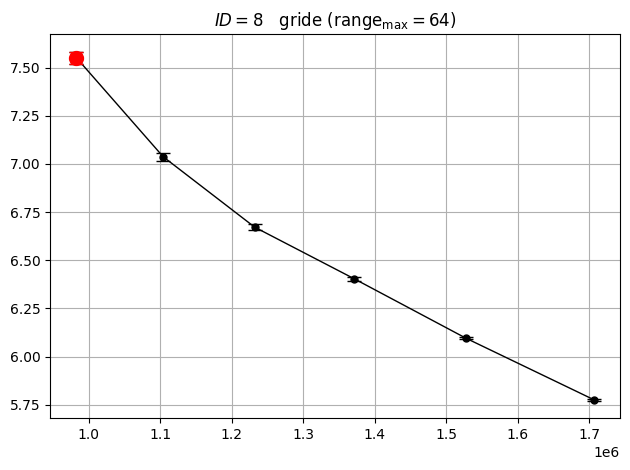

In [4]:
algorithms = ["gride"]
n_min = 100
range_max = 64
args = {
    "2NN": {"n_min": n_min, "algorithm": "base", "mu_fraction": 0.9, "set_attr": False},
    "gride": {"range_max": range_max, "d0": 0.001, "d1": 1000, "set_attr": False},
}
intrinsic_dims = {algorithm: None for algorithm in algorithms}
intrinsic_dim_errs = {algorithm: None for algorithm in algorithms}
intrinsic_dim_scales = {algorithm: None for algorithm in algorithms}
for algorithm in algorithms:
    function = f"return_id_scaling_{algorithm}"
    if hasattr(data, function):
        intrinsic_dim_, intrinsic_dim_err_, intrinsic_dim_scale_ = getattr(
            data, function
        )(**args[algorithm])
        intrinsic_dims[algorithm] = intrinsic_dim_
        intrinsic_dim_errs[algorithm] = intrinsic_dim_err_
        intrinsic_dim_scales[algorithm] = intrinsic_dim_scale_
if algorithms == ["2NN", "gride"]:
    closest_scales = np.array(
        object=[
            np.argmin(a=np.abs(intrinsic_dim_scales["2NN"] - intrinsic_dim_scale))
            for intrinsic_dim_scale in intrinsic_dim_scales["gride"]
        ]
    )
    distances = np.abs(intrinsic_dims["2NN"][closest_scales] - intrinsic_dims["gride"])
    errors = np.sqrt(
        intrinsic_dim_errs["2NN"][closest_scales] ** 2
        + intrinsic_dim_errs["gride"] ** 2
    )
    intrinsic_dim_scale = intrinsic_dim_scales["gride"][np.argmin(a=distances / errors)]
    intrinsic_dim_err = np.sqrt(
        intrinsic_dim_errs["gride"][np.argmin(a=distances / errors)] ** 2
        + errors[np.argmin(a=distances / errors)] ** 2
    )
    intrinsic_dim = intrinsic_dims["gride"][np.argmin(a=distances / errors)]
else:
    intrinsic_dim = intrinsic_dims["gride"][0]
    intrinsic_dim_err = intrinsic_dim_errs["gride"][0]
    intrinsic_dim_scale = intrinsic_dim_scales["gride"][0]
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"$ID = {np.round(a=intrinsic_dim):.0f}$"
params = [f"{algorithm}" for algorithm in algorithms]
if "2NN" in params:
    params[params.index("2NN")] += rf" ($n_\text{{min}} = {n_min}$)"
if "gride" in params:
    params[params.index("gride")] += rf" ($\text{{range}}_\text{{max}} = {range_max}$)"
params = r"$\quad$" + r"$\quad$".join(params)
ax.set(aspect="auto", title=title + params)
for algorithm in algorithms:
    ax.errorbar(
        x=intrinsic_dim_scales[algorithm],
        y=intrinsic_dims[algorithm],
        yerr=intrinsic_dim_errs[algorithm],
        fmt="o-",
        markersize=5,
        color="black",
        linewidth=1,
        elinewidth=1,
        capsize=5,
        zorder=2,
    )
    ax.errorbar(
        x=intrinsic_dim_scale,
        y=intrinsic_dim,
        yerr=intrinsic_dim_err,
        fmt="o",
        markersize=10,
        color="red",
        elinewidth=1,
        capsize=5,
        zorder=3,
    )
ax.grid()

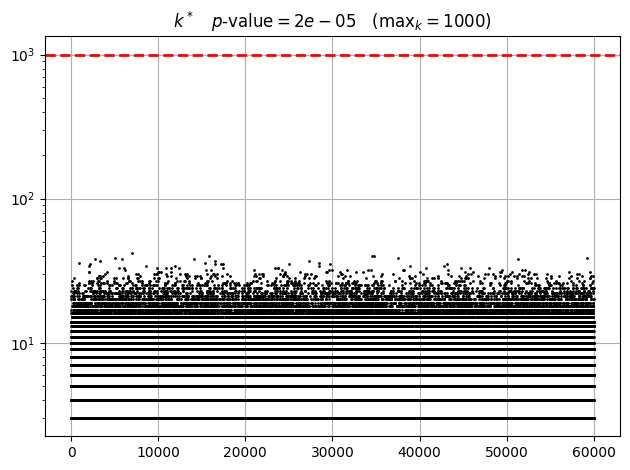

In [ ]:
p = 1e-6
p_value = max(1 / data.N, p)
Dthr = chi2.ppf(q=1 - p_value, df=1)
data.set_id(int(np.round(a=intrinsic_dim)))
data.compute_kstar(Dthr=Dthr)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"$k^* \quad p$-value$ = {p_value:.0e}$"
params = rf"$\quad (\text{{max}}_{{k}} = {data.maxk})$"
step = 10000
ax.set(
    aspect="auto", title=title + params, xticks=range(0, data.N + 1, step), yscale="log"
)
ax.scatter(x=range(data.N), y=data.kstar, s=1, c="black", zorder=2)
ax.axhline(y=data.maxk, c="red", ls="--", lw=2, zorder=2)
ax.grid()

In [6]:
density_estimator = None
alpha = 0.7
if density_estimator == "BMTI":
    data.compute_density_BMTI(
        delta_F_inv_cov="LSDI",
        comp_log_den_err=True,
        solver="sp_direct",
        alpha=alpha,
    )
else:
    _ = data.compute_density_PAk()

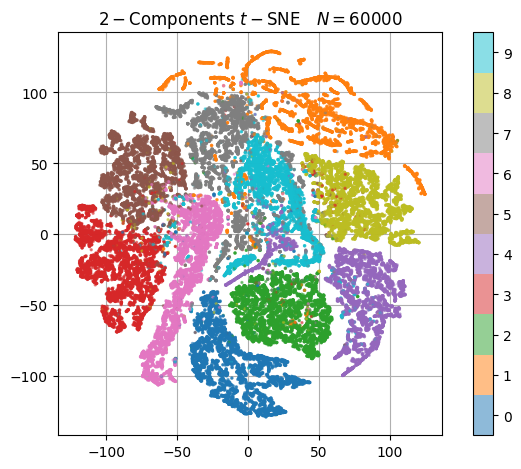

In [7]:
filepath = "./data/t_SNE.npy"
try:
    with open(file=filepath, mode="rb") as file:
        t_SNE = np.load(file=file)
except FileNotFoundError:
    truncated_SVD_components = 100
    t_SNE_components = 2
    n = data.kstar.sum() - data.N
    row = np.arange(stop=n, step=1)
    col = np.arange(stop=n, step=1)
    data_ = np.arange(stop=n, step=1, dtype=np.float64)
    l = 0
    for i in range(data.N):
        for k in range(1, data.kstar[i]):
            data_[l] = data.distances[i, k]
            row[l] = i
            col[l] = data.dist_indices[i, k]
            l += 1
    distances = coo_matrix(
        arg1=(data_, (row, col)), shape=(data.N, data.N), dtype=np.float64
    )
    truncated_SVD = TruncatedSVD(
        n_components=truncated_SVD_components,
        algorithm="randomized",
        n_iter=10,
        random_state=10,
    ).fit_transform(X=distances)
    t_SNE = TSNE(
        n_components=t_SNE_components,
        learning_rate="auto",
        n_iter=1000,
        metric="euclidean",
        init="random",
        random_state=10,
    ).fit_transform(X=truncated_SVD)
    with open(file=filepath, mode="wb") as file:
        np.save(file=filepath, arr=t_SNE)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"${t_SNE.shape[1]}-$Components $t-$SNE"
params = rf"$\quad N = {data.N}$"
ax.set(aspect="equal", title=title + params)
ax.scatter(x=t_SNE[:, 0], y=t_SNE[:, 1], s=2, c=y, cmap="tab10", alpha=0.5, zorder=2)
cbar = fig.colorbar(
    mappable=ax.collections[-1],
    ax=ax,
    boundaries=np.arange(stop=len(distinct_digits) + 1, step=1) - 0.5,
)
cbar.set_ticks(ticks=distinct_digits)
cbar.set_ticklabels(ticklabels=distinct_digits)
ax.grid()

In [8]:
H = np.empty_like(prototype=data.distances, dtype=np.float64)
F = np.zeros(shape=data.distances.shape, dtype=np.float64)
H[:, 0] = 0
for i in range(data.N):
    for k in range(1, data.kstar[i]):
        j = data.dist_indices[i, k]
        H[i, k] = data.log_den[i] - data.log_den[j]
        H[i, k] /= np.sqrt(data.log_den_err[i] ** 2 + data.log_den_err[j] ** 2)
        H[i, k] = (1 + special.erf(-H[i, k] / np.sqrt(2))) / 2
n = 0
for i in range(data.N):
    t = 1
    for k in range(1, data.kstar[i]):
        F[i, k] = t * H[i, k]
        t *= 1 - H[i, k]
        n += 1
    normalization = np.sum(F[i, :])
    if normalization != 0:
        F[i, :] /= normalization
row = np.arange(stop=n, step=1)
col = np.arange(stop=n, step=1)
data_ = np.arange(stop=n, step=1, dtype=np.float64)
l = 0
for i in range(data.N):
    for k in range(1, data.kstar[i]):
        data_[l] = F[i, k]
        row[l] = i
        col[l] = data.dist_indices[i, k]
        l += 1
P = coo_matrix(arg1=(data_, (row, col)), shape=(data.N, data.N), dtype=np.float64)
sparsity = 1 - P.nnz / (P.shape[0] * P.shape[1])
print(rf"P Matrix Sparsity: {sparsity:.4f}")

P Matrix Sparsity: 0.9999


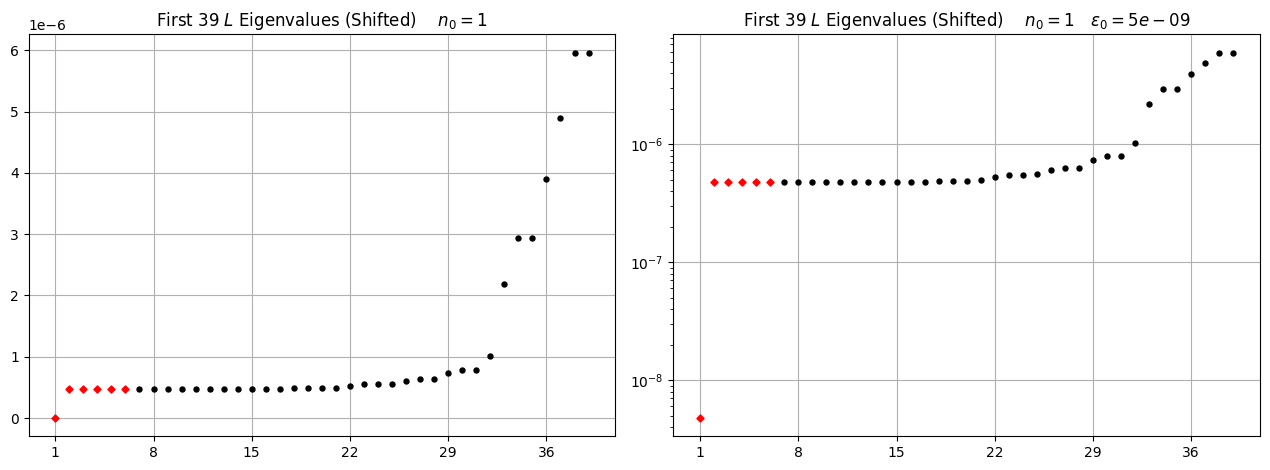

In [9]:
np.random.seed(42)
k = None
eps_ratio = 2
k = int(np.cbrt(data.N)) if k is None else max(k, int(np.cbrt(data.N)))
step = int(k / 5)
s = 1 / k * 500
v0 = np.random.rand(data.N)
machine_epsilon = np.finfo(np.float64).eps
with np.errstate(divide="ignore", invalid="ignore"):
    eigenvalues, eigenvectors = eigs(
        A=P, k=k, sigma=1 - machine_epsilon, which="LM", v0=v0
    )
eigenvalues = np.real(val=1 - eigenvalues)
eigenvectors = np.real(val=eigenvectors)
eigenvalue_indeces = np.argsort(a=eigenvalues)
eigenvalues = eigenvalues[eigenvalue_indeces]
eigenvectors = eigenvectors[:, eigenvalue_indeces]
title = rf"First ${k}$ $L$ Eigenvalues"
n_negative = np.argmax(a=eigenvalues > 0)
if n_negative > 0:
    eigenvalues -= eigenvalues[0]
    n_zeros = np.argmax(a=eigenvalues > 0)
    title += rf" (Shifted) $\quad n_0 = {n_zeros}$"
    eps = 10 ** (np.log10(eigenvalues[n_zeros]) - eps_ratio)
fig, axs = plt.subplots(
    ncols=2,
    figsize=(2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1]),
    layout="tight",
)
xticks = range(1, k + step + 1, step)
for ax, yscale in zip(axs, ["linear", "log"]):
    if n_negative > 0 and yscale == "log":
        title += rf"$\quad \varepsilon_0 = {eps:.0e}$"
    ax.set(aspect="auto", title=title, xticks=xticks, yscale=yscale)
    if n_negative > 0:
        if yscale == "log":
            y_ = [eps] * n_zeros + list(eigenvalues[n_zeros:n_negative])
        else:
            y_ = [0] * n_zeros + list(eigenvalues[n_zeros:n_negative])
        ax.scatter(x=range(1, n_negative + 1), y=y_, s=s, c="red", marker="D", zorder=2)
    ax.scatter(
        x=range(1 + n_negative, k + 1),
        y=eigenvalues[n_negative:],
        s=s,
        c="black",
        zorder=2,
    )
    ax.grid()

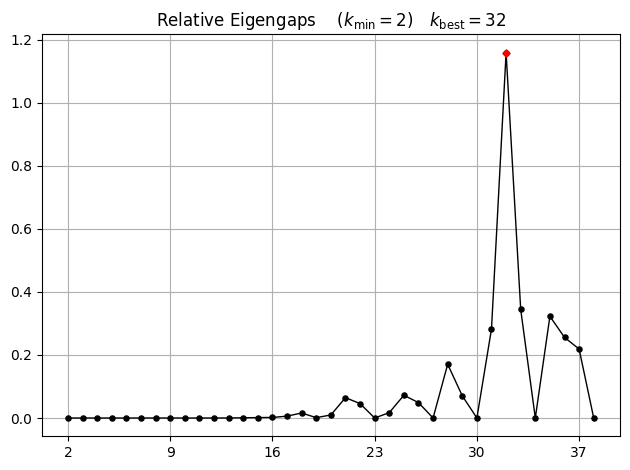

In [10]:
k_min = None
if n_negative > 0:
    k_min = n_zeros + 1 if k_min is None else max(n_zeros, k_min)
else:
    k_min = 2
step = max(int((k - k_min) / 5), 1)
s = 1 / (k - k_min) * 500
markersize = np.sqrt(s)
k_range = range(k_min, k)
eigengaps = np.diff(a=eigenvalues)[np.array(object=k_range) - 1]
relative_eigengaps = eigengaps / eigenvalues[np.array(object=k_range) - 1]
optimal_k_values = np.argsort(a=relative_eigengaps)[::-1] + k_min
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"Relative Eigengaps $\quad (k_\text{{min}} = {k_min}$)"
title += rf"$\quad k_\text{{best}} = {optimal_k_values[0]}$"
ax.set(aspect="auto", title=title, xticks=k_range[::step])
ax.plot(
    k_range,
    relative_eigengaps,
    c="black",
    marker="o",
    markersize=markersize,
    linestyle="-",
    linewidth=1,
    zorder=2,
)
ax.scatter(
    x=k_range[optimal_k_values[0] - k_min],
    y=relative_eigengaps[optimal_k_values[0] - k_min],
    s=s,
    c="red",
    marker="D",
    zorder=2,
)
ax.grid()

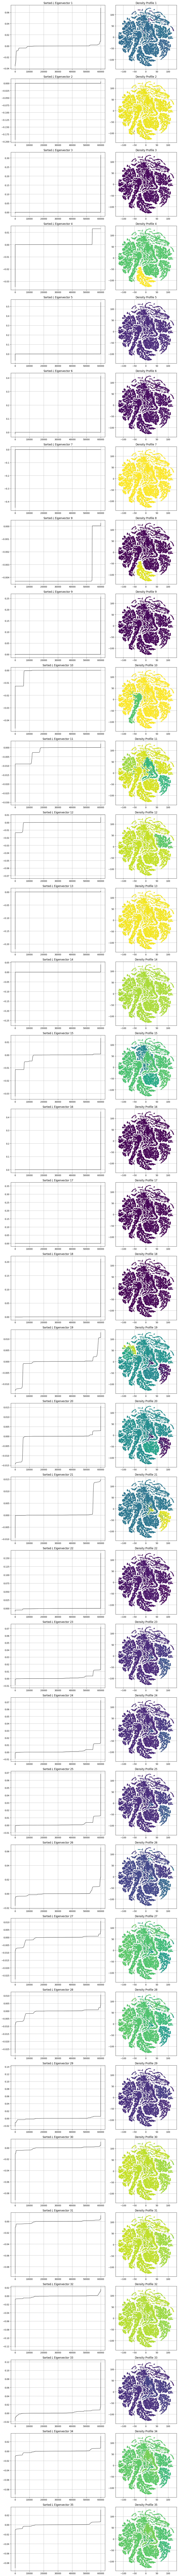

In [11]:
n_profiles = optimal_k_values[0] + 3
fig, axs = plt.subplots(
    nrows=n_profiles,
    ncols=2,
    figsize=(
        2 * plt.rcParams["figure.figsize"][0],
        n_profiles * plt.rcParams["figure.figsize"][1],
    ),
    layout="tight",
)
for profile_index in range(n_profiles):
    title = rf"Sorted $L$ Eigenvector ${profile_index + 1}$"
    axs[profile_index, 0].set(aspect="auto", title=title)
    axs[profile_index, 0].plot(
        np.sort(eigenvectors[:, profile_index]), c="black", lw=1, zorder=2
    )
    axs[profile_index, 0].grid()
    title = rf"Density Profile ${profile_index + 1}$"
    axs[profile_index, 1].set(aspect="equal", title=title)
    axs[profile_index, 1].scatter(
        x=t_SNE[:, 0],
        y=t_SNE[:, 1],
        s=2,
        c=eigenvectors[:, profile_index],
        alpha=0.5,
        zorder=2,
    )
    axs[profile_index, 1].grid()

In [12]:
n_clusters = optimal_k_values[0]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(
    X=eigenvectors[:, :n_clusters]
)
populations = pd.DataFrame(
    data=0,
    index=[f"Cluster {c + 1}" for c in range(n_clusters)],
    columns=[f"Digit {d}" for d in distinct_digits],
)
for label in np.unique(ar=kmeans.labels_):
    unique, unique_counts = np.unique(ar=y[kmeans.labels_ == label], return_counts=True)
    for distinct_digit, distinct_digit_counts in zip(unique, unique_counts):
        populations.loc[rf"Cluster {label + 1}", rf"Digit {distinct_digit}"] = (
            distinct_digit_counts
        )
purity = lambda row: row.max() / row.sum()
populations["Purity"] = populations.apply(func=purity, axis=1)
populations["Population"] = populations.iloc[:, :-1].apply(func=sum, axis=1)
highlight = lambda row: [
    (
        "color: green"
        if digit == row.max()
        else "color: red" if digit == row[row < row.max()].max() else ""
    )
    for digit in row
]
display(
    populations.style.apply(
        func=highlight, axis=1, subset=populations.columns[:-2]
    ).format({"Purity": "{:.0%}"})
)

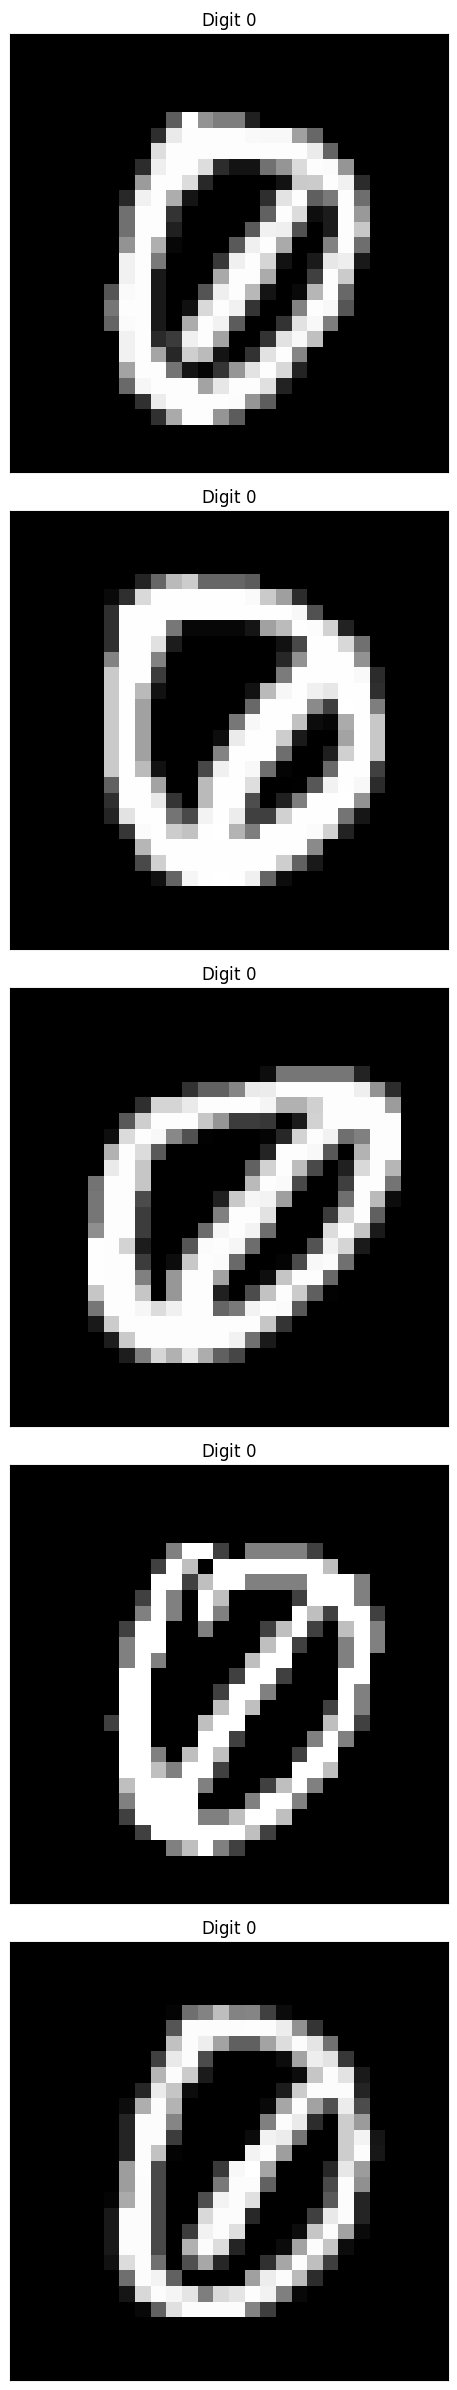

In [13]:
label = 8
max_digit = 5
max_images = 10
label_images = data.X[kmeans.labels_ == label - 1, :]
label_digits = y[kmeans.labels_ == label - 1]
digits = []
if digits:
    mask = np.isin(element=label_digits, test_elements=digits)
    label_images = label_images[mask, :][:max_digit, :]
    label_digits = label_digits[mask][:max_digit]
else:
    label_images = label_images[:max_images, :]
    label_digits = label_digits[:max_images]
fig, axs = plt.subplots(
    nrows=len(label_digits),
    figsize=(
        plt.rcParams["figure.figsize"][0],
        nrows * plt.rcParams["figure.figsize"][1],
    ),
    layout="tight",
)
if len(label_digits) == 1:
    axs = [axs]
for ax, label_image, label_digit in zip(axs, label_images, label_digits):
    title = rf"Digit ${label_digit}$"
    ax.set(aspect="equal", title=title, xticks=[], yticks=[])
    label_image = label_image.reshape((image_size, image_size))
    ax.imshow(X=label_image, cmap="gray", vmin=0, vmax=255)

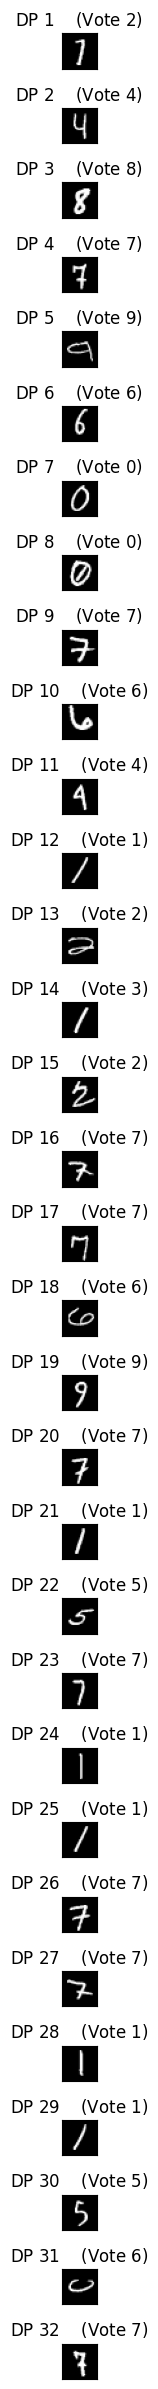

In [14]:
density_peaks = np.zeros(shape=(n_clusters, data.X.shape[1]), dtype=np.float64)
for index, label in enumerate(range(n_clusters)):
    mask = kmeans.labels_ == label
    subset_index = np.argmax(a=data.log_den[mask])
    parent_index = np.flatnonzero(mask)[subset_index]
    density_peaks[index, :] = data.X[parent_index, :]
majority_votes = np.empty_like(prototype=range(n_clusters), dtype=np.int8)
majority_labels = np.empty_like(prototype=kmeans.labels_, dtype=np.int8)
for label in np.unique(ar=kmeans.labels_):
    unique, unique_counts = np.unique(ar=y[kmeans.labels_ == label], return_counts=True)
    majority_votes[label] = unique[np.argmax(a=unique_counts)]
    majority_labels[kmeans.labels_ == label] = majority_votes[label]
fig, axs = plt.subplots(
    nrows=len(density_peaks),
    figsize=(
        plt.rcParams["figure.figsize"][0],
        nrows * plt.rcParams["figure.figsize"][1],
    ),
)
if len(density_peaks) == 1:
    axs = [axs]
for ax, cluster_index, density_peak in zip(axs, range(n_clusters), density_peaks):
    title = rf"DP ${cluster_index + 1}$"
    title += rf"$\quad$ (Vote {majority_votes[cluster_index]})"
    ax.set(aspect="equal", title=title, xticks=[], yticks=[])
    density_peak_image = density_peak.reshape((image_size, image_size))
    ax.imshow(X=density_peak_image, cmap="gray", vmin=0, vmax=255)
fig.tight_layout()

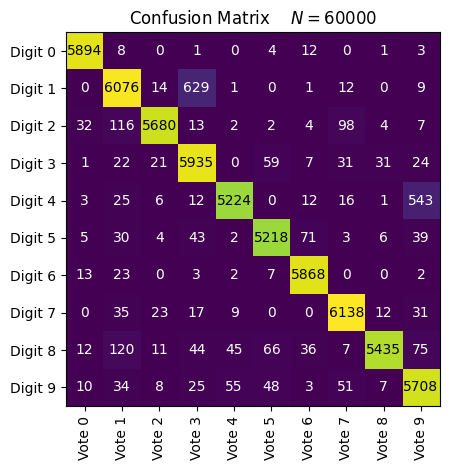

In [15]:
color_treshold = 1000
conf_matrix = confusion_matrix(y_true=y, y_pred=majority_labels)
distinct_labels = np.unique(ar=majority_labels)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"Confusion Matrix $\quad N = {data.N}$"
ax.set(
    aspect="equal",
    title=title,
    xticks=range(len(distinct_digits)),
    yticks=range(len(distinct_digits)),
    xticklabels=[rf"Vote {label}" for label in distinct_digits],
    yticklabels=[rf"Digit {digit}" for digit in distinct_digits],
)
for tick in ax.get_xticklabels():
    tick.set_rotation(s="vertical")
ax.imshow(X=conf_matrix)
color = lambda i, j, conf_matrix: (
    "white" if (i == j and conf_matrix[i, j] < color_treshold) or (i != j) else "black"
)
for i in range(len(distinct_digits)):
    for j in range(len(distinct_digits)):
        ax.text(
            x=j,
            y=i,
            s=f"{conf_matrix[i, j]}",
            ha="center",
            va="center",
            color=color(i=i, j=j, conf_matrix=conf_matrix),
        )

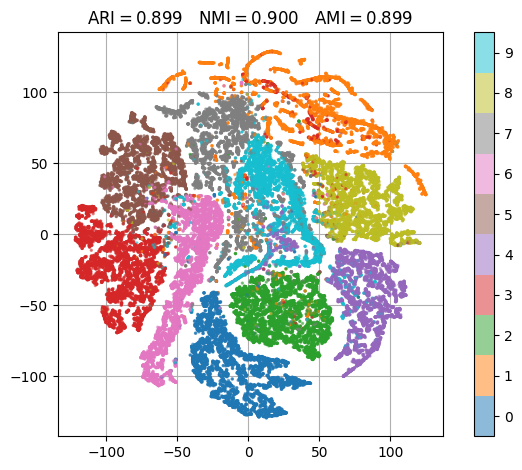

In [16]:
ARI = adjusted_rand_score(labels_true=y, labels_pred=majority_labels)
NMI = normalized_mutual_info_score(
    labels_true=y,
    labels_pred=majority_labels,
    average_method="arithmetic",
)
AMI = adjusted_mutual_info_score(
    labels_true=y,
    labels_pred=majority_labels,
    average_method="arithmetic",
)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"], layout="tight")
title = rf"$\text{{ARI}} = {ARI:.3f}$"
title += rf"$\quad \text{{NMI}} = {NMI:.3f}$"
title += rf"$\quad \text{{AMI}} = {AMI:.3f}$"
ax.set(aspect="equal", title=title)
ax.scatter(
    x=t_SNE[:, 0],
    y=t_SNE[:, 1],
    s=2,
    c=majority_labels,
    cmap="tab10",
    alpha=0.5,
    zorder=2,
)
cbar = fig.colorbar(
    mappable=ax.collections[-1],
    ax=ax,
    boundaries=np.arange(stop=len(distinct_digits) + 1, step=1) - 0.5,
)
cbar.set_ticks(ticks=distinct_digits)
cbar.set_ticklabels(ticklabels=distinct_digits)
ax.grid()